In [1]:
# Setup & Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version.split()[0])


Python version: 3.13.5


In [2]:
# Load COMPAS dataset
df = pd.read_csv("compas-scores-two-years.csv")

print("Shape:", df.shape)
df.head()


Shape: (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# Keep relevant features
cols = ['age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']
data = df[cols].dropna()

# Encode sex (Male=1, Female=0)
data['sex'] = data['sex'].map({'Male': 1, 'Female': 0})

# Simplify race (focus Black vs White vs Other)
data['race_cat'] = data['race'].apply(
    lambda x: 'Black' if 'African' in x or x == 'Black' 
              else ('White' if x in ['Caucasian', 'White'] else 'Other')
)

# Encode charge degree (M=0, F=1)
data['c_charge_degree'] = data['c_charge_degree'].map({'M': 0, 'F': 1})

print("Processed data shape:", data.shape)
data.head()


Processed data shape: (7214, 7)


,age,sex,race,priors_count,c_charge_degree,two_year_recid,race_cat
0,69,1,Other,0,1,0,Other
1,34,1,African-American,0,1,1,Black
2,24,1,African-American,4,1,1,Black
3,23,1,African-American,1,1,0,Black
4,43,1,Other,2,1,0,Other


In [4]:
X = data[['age', 'sex', 'priors_count', 'c_charge_degree']]
y = data['two_year_recid']

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, data, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 5049 Test size: 2165


In [5]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Accuracy: 0.6748267898383372
AUC: 0.7249358877138798
Precision: 0.67
Recall: 0.5491803278688525


In [6]:
def confusion_stats(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}

def group_metrics(y_true, y_pred):
    stats = confusion_stats(y_true, y_pred)
    positive_rate = np.mean(y_pred)
    tpr = stats['tp'] / (stats['tp'] + stats['fn']) if (stats['tp'] + stats['fn'])>0 else np.nan
    fpr = stats['fp'] / (stats['fp'] + stats['tn']) if (stats['fp'] + stats['tn'])>0 else np.nan
    return {'positive_rate': positive_rate, 'tpr': tpr, 'fpr': fpr}

protected_attr = 'race_cat'
results = {}
for g in df_test[protected_attr].unique():
    mask = df_test[protected_attr] == g
    results[g] = group_metrics(y_test[mask], y_pred[mask])

# Extract Black vs White comparisons
pr_black, pr_white = results['Black']['positive_rate'], results['White']['positive_rate']
spd = pr_black - pr_white
di = pr_black / pr_white if pr_white > 0 else np.nan
tpr_diff = results['Black']['tpr'] - results['White']['tpr']
fpr_diff = results['Black']['fpr'] - results['White']['fpr']

print("Fairness Metrics:")
print("SPD (Black - White):", spd)
print("DI (Black / White):", di)
print("TPR diff:", tpr_diff)
print("FPR diff:", fpr_diff)

pd.DataFrame(results).T


Fairness Metrics:
SPD (Black - White): 0.2589094706532429
DI (Black / White): 2.115057965635439
TPR diff: 0.28498366625609167
FPR diff: 0.1681224496484817


,positive_rate,tpr,fpr
Black,0.491103,0.669014,0.309353
Other,0.250737,0.379310,0.154639
White,0.232194,0.384030,0.141230


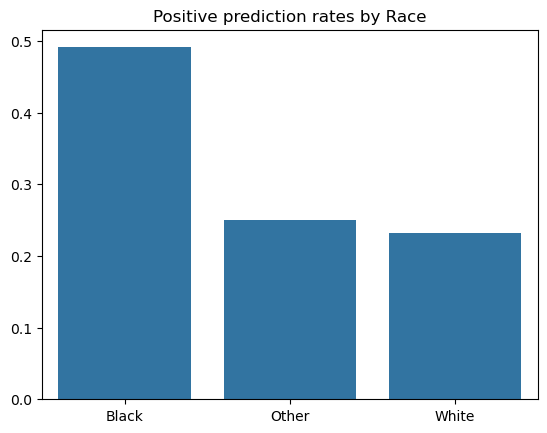

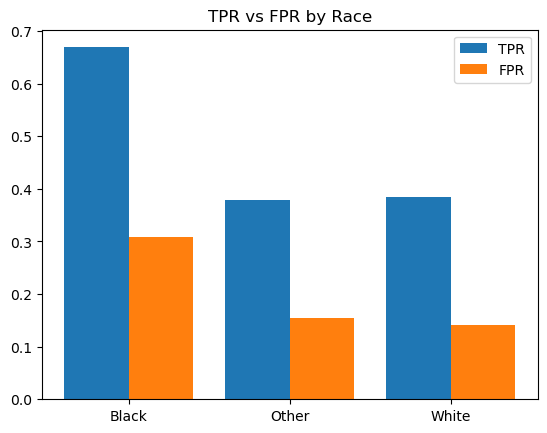

In [7]:
# Positive prediction rates
sns.barplot(x=list(results.keys()), y=[results[g]['positive_rate'] for g in results])
plt.title("Positive prediction rates by Race")
plt.show()

# TPR & FPR comparison
x = np.arange(len(results))
tprs = [results[g]['tpr'] for g in results]
fprs = [results[g]['fpr'] for g in results]

plt.bar(x-0.2, tprs, width=0.4, label="TPR")
plt.bar(x+0.2, fprs, width=0.4, label="FPR")
plt.xticks(x, list(results.keys()))
plt.legend()
plt.title("TPR vs FPR by Race")
plt.show()


In [8]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights to balance across race groups
sample_weights = compute_sample_weight(class_weight="balanced", y=df_train['race_cat'])

# Train logistic regression with sample weights
clf_weighted = LogisticRegression(max_iter=1000)
clf_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Predict
y_pred_weighted = clf_weighted.predict(X_test_scaled)

# Evaluate group metrics
weighted_results = {}
for g in df_test['race_cat'].unique():
    mask = df_test['race_cat']==g
    weighted_results[g] = group_metrics(y_test[mask], y_pred_weighted[mask])

pd.DataFrame(weighted_results).T


,positive_rate,tpr,fpr
Black,0.415480,0.589789,0.237410
Other,0.182891,0.282759,0.108247
White,0.192308,0.342205,0.102506


In [13]:
from fairlearn.postprocessing import ThresholdOptimizer

# Train baseline classifier
clf2 = LogisticRegression(max_iter=1000)
clf2.fit(X_train_scaled, y_train)

# Apply ThresholdOptimizer for equalized odds
to = ThresholdOptimizer(
    estimator=clf2, 
    constraints="equalized_odds", 
    prefit=True
)
to.fit(X_train_scaled, y_train, sensitive_features=df_train['race_cat'])

# Predict with fairness constraints
y_post = to.predict(X_test_scaled, sensitive_features=df_test['race_cat'])

# Evaluate after post-processing
post_results = {}
for g in df_test['race_cat'].unique():
    mask = df_test['race_cat'] == g
    post_results[g] = group_metrics(y_test[mask], y_post[mask])

pd.DataFrame(post_results).T


,positive_rate,tpr,fpr
Black,0.346085,0.494718,0.194245
Other,0.277286,0.393103,0.190722
White,0.277778,0.429658,0.186788


In [15]:
# Combine metrics into one DataFrame
comparison = pd.DataFrame({
    'Group': list(results.keys()),
    'Baseline_PR': [results[g]['positive_rate'] for g in results],
    'Weighted_PR': [weighted_results[g]['positive_rate'] for g in results],
    'Post_PR': [post_results[g]['positive_rate'] for g in results],
    
    'Baseline_TPR': [results[g]['tpr'] for g in results],
    'Weighted_TPR': [weighted_results[g]['tpr'] for g in results],
    'Post_TPR': [post_results[g]['tpr'] for g in results],
    
    'Baseline_FPR': [results[g]['fpr'] for g in results],
    'Weighted_FPR': [weighted_results[g]['fpr'] for g in results],
    'Post_FPR': [post_results[g]['fpr'] for g in results]
})
comparison


,Group,Baseline_PR,Weighted_PR,Post_PR,Baseline_TPR,Weighted_TPR,Post_TPR,Baseline_FPR,Weighted_FPR,Post_FPR
0,Black,0.491103,0.415480,0.346085,0.669014,0.589789,0.494718,0.309353,0.237410,0.194245
1,Other,0.250737,0.182891,0.277286,0.379310,0.282759,0.393103,0.154639,0.108247,0.190722
2,White,0.232194,0.192308,0.277778,0.384030,0.342205,0.429658,0.141230,0.102506,0.186788


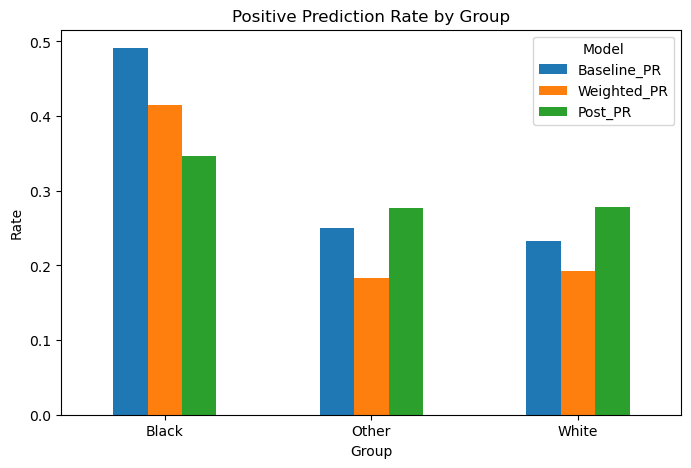

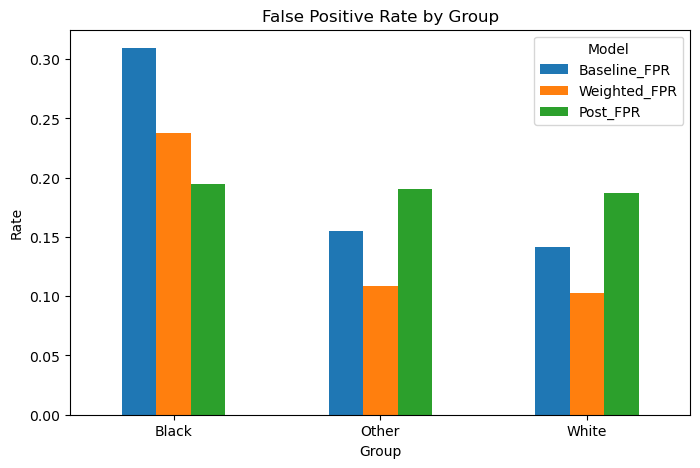

In [17]:
import matplotlib.pyplot as plt

# Positive Prediction Rate
comparison.set_index('Group')[['Baseline_PR','Weighted_PR','Post_PR']].plot(
    kind='bar', figsize=(8,5)
)
plt.title("Positive Prediction Rate by Group")
plt.ylabel("Rate")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.show()


# False Positive Rate
comparison.set_index('Group')[['Baseline_FPR','Weighted_FPR','Post_FPR']].plot(
    kind='bar', figsize=(8,5)
)
plt.title("False Positive Rate by Group")
plt.ylabel("Rate")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.show()


In [18]:
import scipy.stats as stats
import numpy as np

# --- Chi-square test for Positive Prediction Rates ---
# Build contingency table: Group vs Predicted Label
def chi_square_test(y_true, y_pred, groups):
    contingency = pd.crosstab(groups, y_pred)
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    return chi2, p

# Baseline
chi2_base, p_base = chi_square_test(y_test, y_pred, df_test['race_cat'])
# Weighted
chi2_weight, p_weight = chi_square_test(y_test, y_pred_weighted, df_test['race_cat'])
# Post-processed
chi2_post, p_post = chi_square_test(y_test, y_post, df_test['race_cat'])

print("Chi-square test for independence (Positive Prediction Rates):")
print(f"Baseline: chi2={chi2_base:.2f}, p={p_base:.4f}")
print(f"Weighted: chi2={chi2_weight:.2f}, p={p_weight:.4f}")
print(f"Post-processed: chi2={chi2_post:.2f}, p={p_post:.4f}")


Chi-square test for independence (Positive Prediction Rates):
Baseline: chi2=148.67, p=0.0000
Weighted: chi2=130.19, p=0.0000
Post-processed: chi2=11.78, p=0.0028
